In [1]:
# goal: reproduce figure 5 from dean's artiphysiology paper
import numpy as np
import torch
import xarray as xr
from torchvision import datasets, models, transforms
from scipy.stats import kurtosis
import os
from Visualizer import *

# params
net_name = "vgg16"
snapshot = "epoch24"
layer_name = "conv8"
data_dir = "./data"

visualizer = Visualizer(net_name, layer_name, snapshot, data_dir)

In [3]:
# want n units with highest correlation that pass kurtosis filter    
selective_units = visualizer
    .get_n_most_selective_units(10, apc_fits, apc_models, outputs_tt)
print(selective_units)

[[6.60000000e+01 2.12800000e+03 5.81346458e-01]
 [2.71000000e+02 3.16400000e+03 5.51607941e-01]
 [9.80000000e+01 5.96130000e+04 5.44746991e-01]
 [4.71000000e+02 5.98540000e+04 5.36599081e-01]
 [3.30000000e+01 3.03100000e+03 5.01465360e-01]
 [8.90000000e+01 6.39670000e+04 4.97943967e-01]
 [4.80000000e+02 5.57580000e+04 4.91861680e-01]
 [4.88000000e+02 5.89750000e+04 4.90578314e-01]
 [1.66000000e+02 6.32660000e+04 4.74645798e-01]
 [4.78000000e+02 1.44560000e+04 4.71476707e-01]]


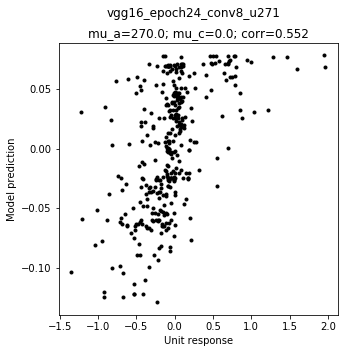

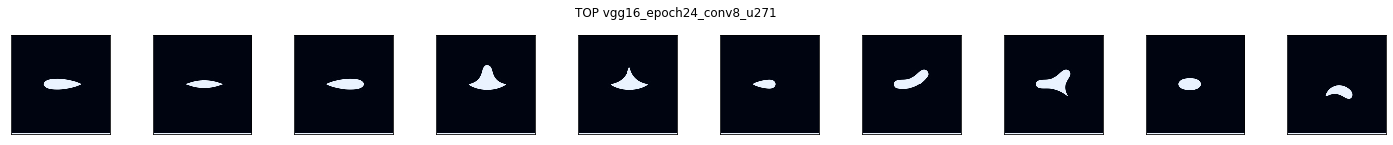

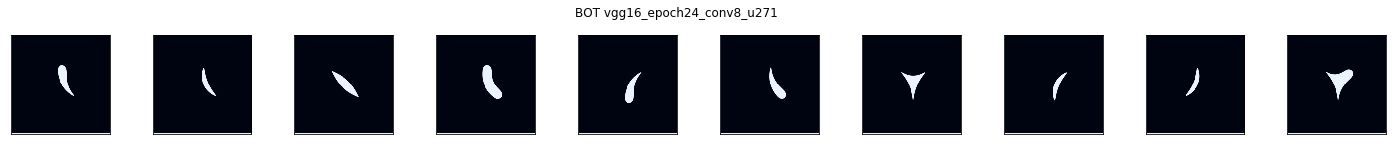

In [2]:
i_unit = 271
save_fig = False

visualizer.plot_unit_summary(i_unit, save_fig)

/home/briardoty/Source/neuro511-artiphysiology/util/visualization_functions.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(25, 4))
/home/briardoty/Source/neuro511-artiphysiology/util/visualization_functions.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, figsize=(5, 5))
/home/briardoty/Source/neuro511-artiphysiology/util/visualization_functions.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) 

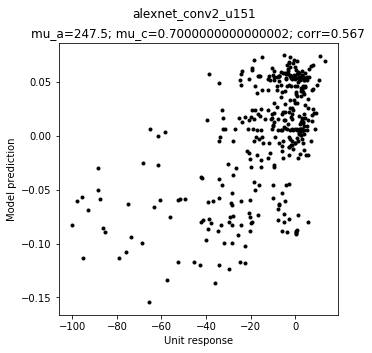

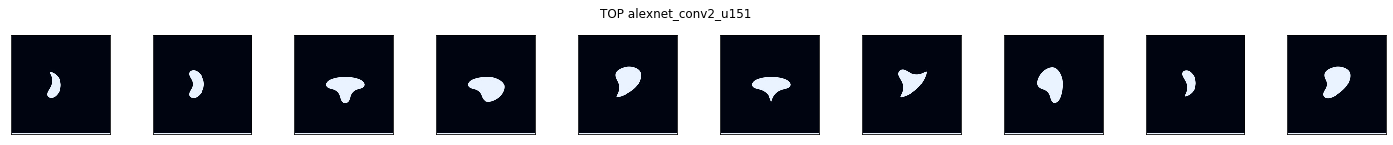

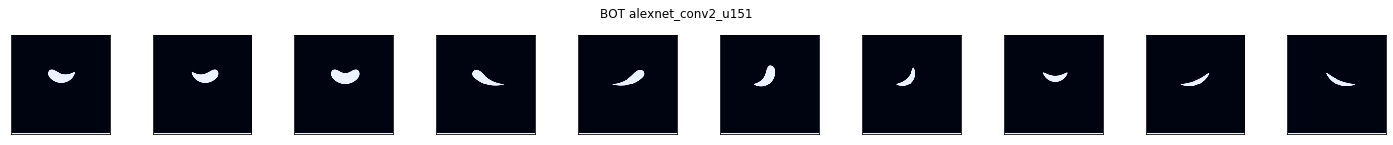

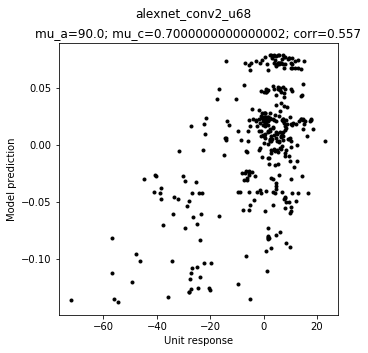

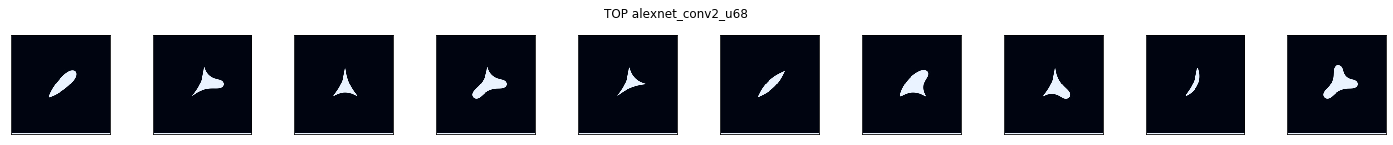

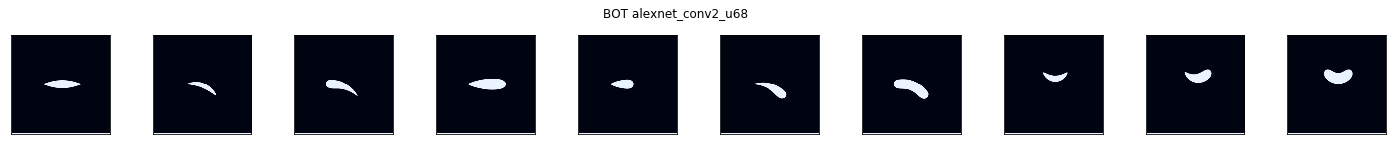

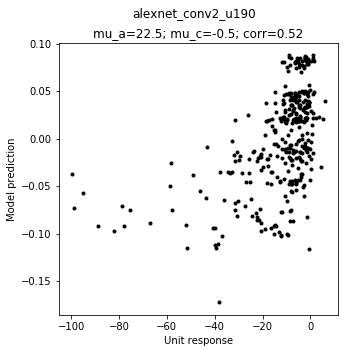

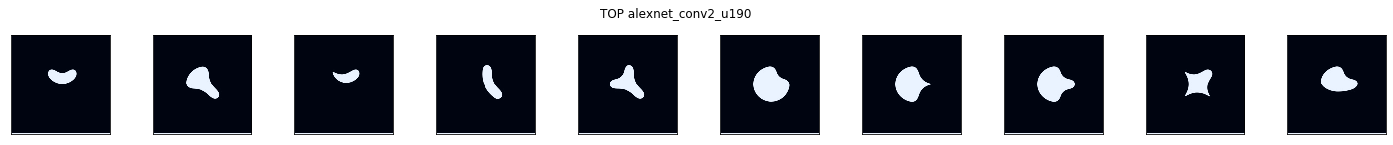

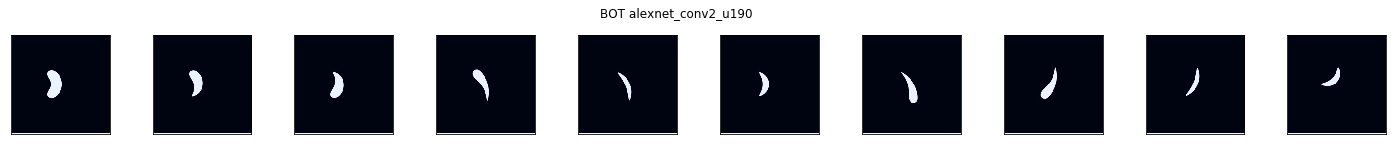

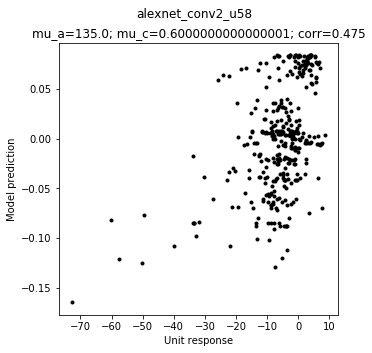

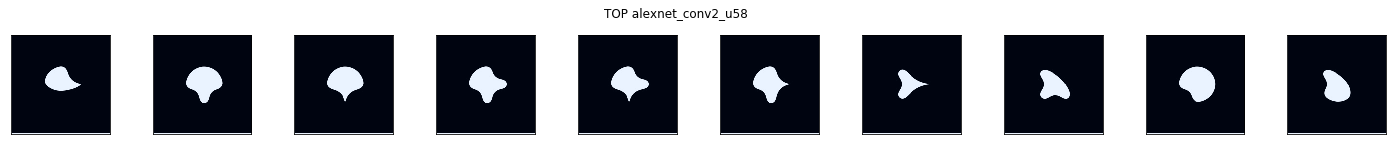

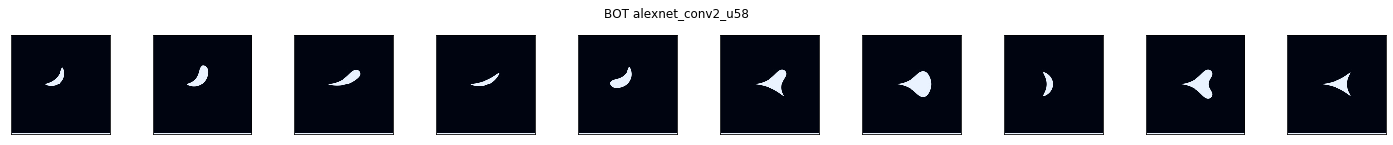

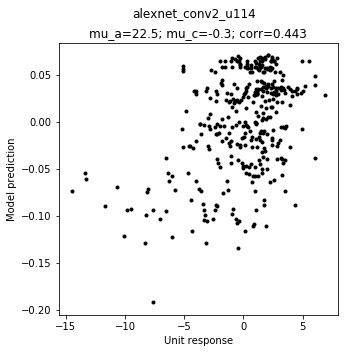

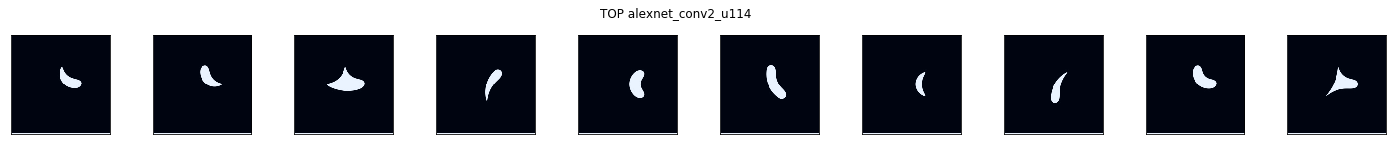

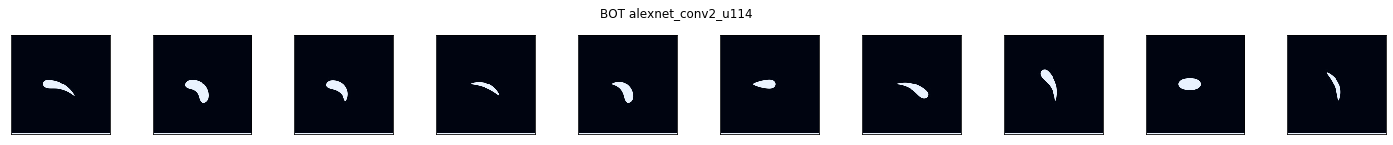

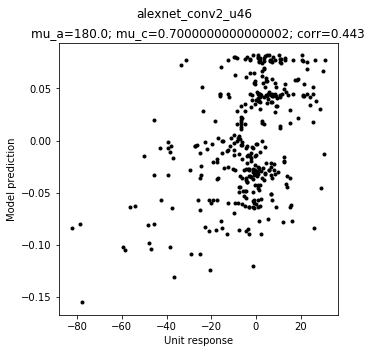

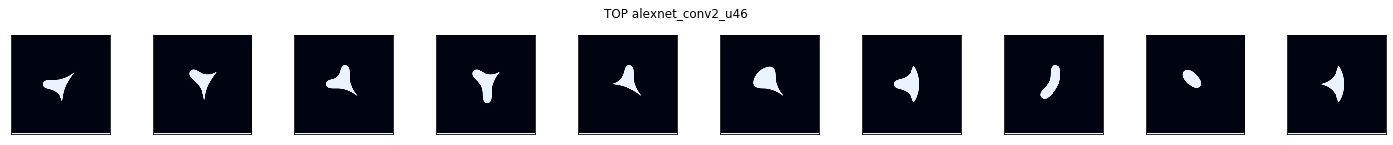

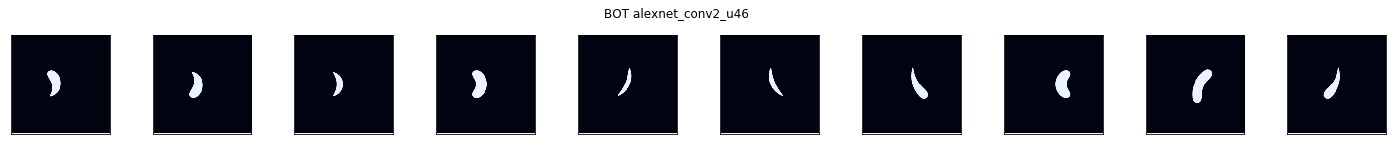

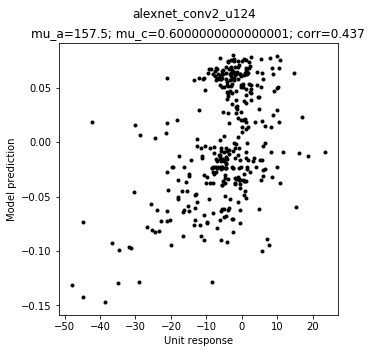

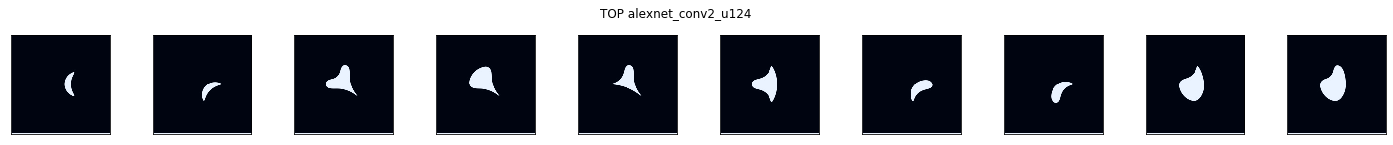

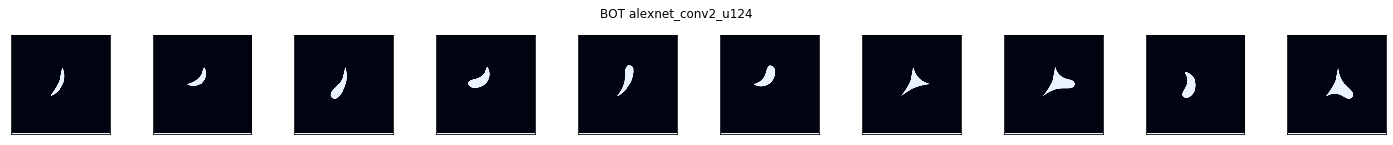

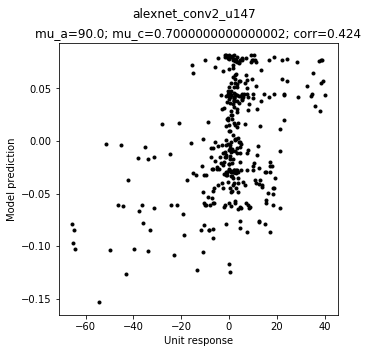

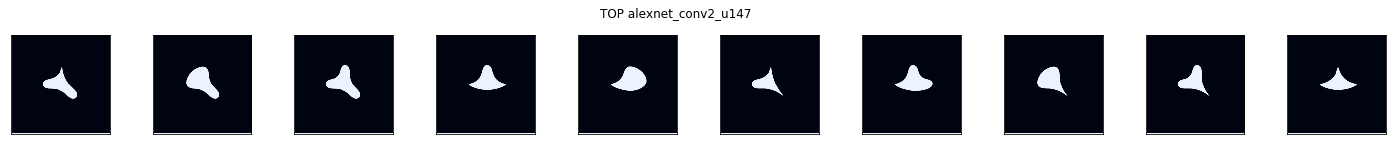

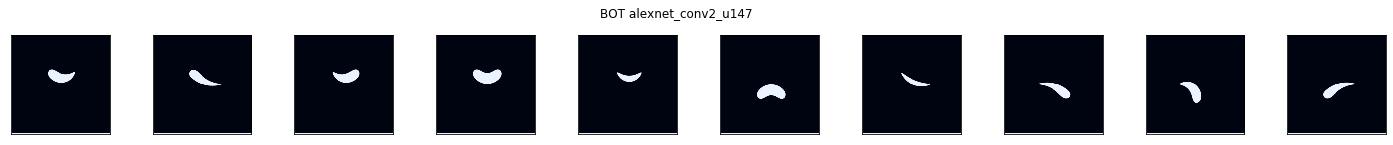

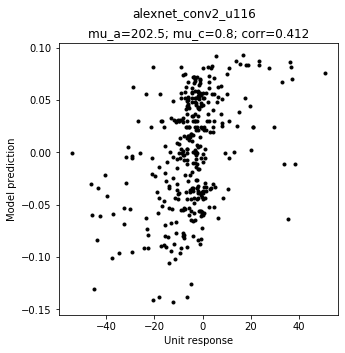

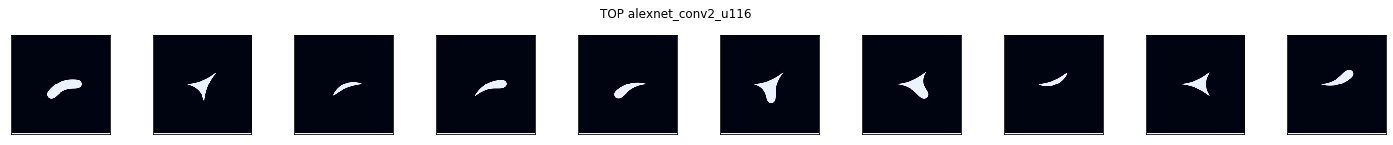

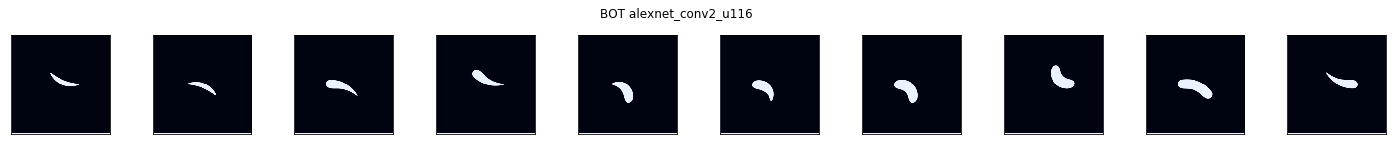

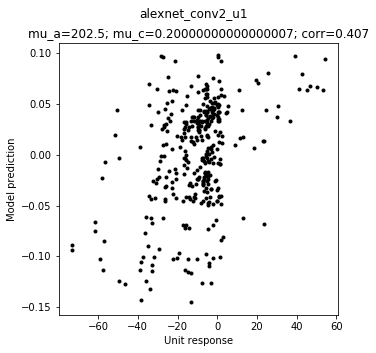

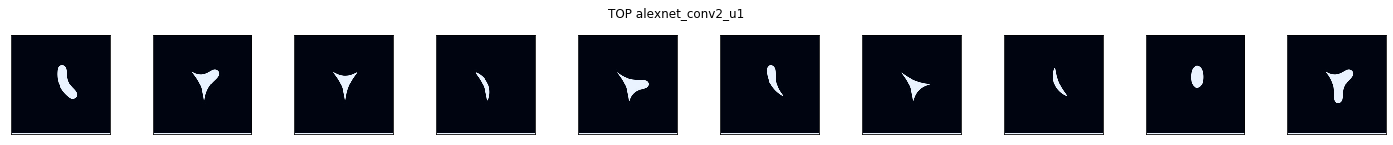

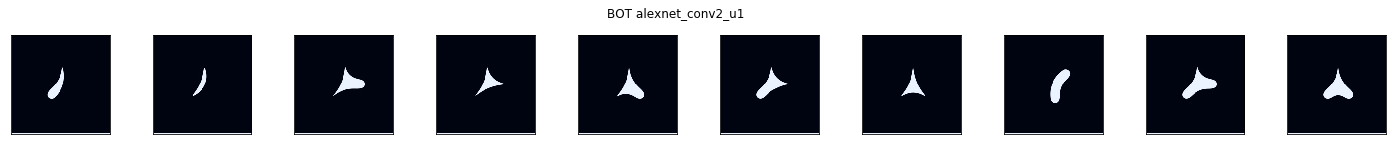

In [42]:
for (i_unit, i_model, corr) in selective_units:
    i_unit = int(i_unit)
    plot_apc_fits_for_unit(net_name, layer_name, i_unit, apc_fits, apc_models, 
                       outputs_tt, save_fig=False)
    display_top_and_bottom(net_name, layer_name, unit=i_unit, n=10, 
                       outputs_tt=outputs_tt, save_fig=False)

In [8]:
# validate correlation
(i_unit, i_model, corr) = selective_units[7]
unit_resp = get_unit_responses(outputs_tt, int(i_unit))
pred_resp = apc_models.resp[:, int(i_model)]
np.corrcoef(unit_resp, pred_resp)

array([[1.        , 0.38857253],
       [0.38857253, 1.        ]])